In [2]:
# PART 1: SETUP ENVIRONMENT

# Check GPU availability
!nvidia-smi

# Install required packages
!pip install ultralytics --quiet
!pip install pydicom --quiet
!pip install opencv-python --quiet
!pip install tqdm --quiet
!pip install kaggle --quiet

Sat Nov 22 11:47:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# PART 2: SETUP KAGGLE API (ONE-TIME)

# Upload your kaggle.json file when prompted
from google.colab import files
print("📁 Upload your kaggle.json file:")
uploaded = files.upload()

# Setup Kaggle credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Verify setup
!kaggle datasets list


📁 Upload your kaggle.json file:


Saving kaggle.json to kaggle.json
ref                                                             title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
wardabilal/spotify-global-music-dataset-20092025                Spotify Global Music Dataset (2009–2025)               1289021  2025-11-11 09:43:05.933000           2743         47  1.0              
sadiajavedd/students-academic-performance-dataset               Students_Academic_Performance_Dataset                     8907  2025-10-23 04:16:35.563000           8725        222  1.0              
kainatjamil12/niteee                                            Netflix Movies and TV Shows Comprehensive Catalogs     1401948  2025-11-19 04:22:09.357000            

In [4]:
# ========================================
# PART 3: DOWNLOAD 1024PX DATASET
# ========================================

# Download VinBigData 1024px JPG Dataset (~3.6-4 GB)
!kaggle datasets download -d sunghyunjun/vinbigdata-1024-jpg-dataset

# Unzip the dataset
!unzip -q vinbigdata-1024-jpg-dataset.zip -d /content/vinbigdata

# Verify download
!ls -lh /content/vinbigdata
print("✅ 1024px dataset downloaded successfully!")


Dataset URL: https://www.kaggle.com/datasets/sunghyunjun/vinbigdata-1024-jpg-dataset
License(s): CC0-1.0
100% 3.56G/3.58G [00:33<00:00, 101MB/s]
100% 3.58G/3.58G [00:33<00:00, 114MB/s]
total 11M
drwxr-xr-x 2 root root 184K Nov 22 11:50 test
drwxr-xr-x 2 root root 928K Nov 22 11:50 train
-rw-r--r-- 1 root root 9.1M Feb 15  2021 train.csv
✅ 1024px dataset downloaded successfully!


In [8]:
# ========================================
# PART 4: IMPORT LIBRARIES
# ========================================

import torch
import os
from ultralytics import YOLO
import pandas as pd
import random
from shutil import copyfile
from PIL import Image
import cv2
import numpy as np
import glob
import yaml
from tqdm.notebook import tqdm
from concurrent.futures import ProcessPoolExecutor as ThreadPoolExecutor, as_completed

print("✅ Libraries imported successfully!")


✅ Libraries imported successfully!


In [9]:
# Quick test
from ultralytics import YOLO
print(f"Ultralytics version: {YOLO.__version__ if hasattr(YOLO, '__version__') else 'installed'}")
print("✅ YOLOv8 ready to use!")


Ultralytics version: installed
✅ YOLOv8 ready to use!


In [10]:
# ========================================
# PART 5: CONFIGURE PATHS FOR COLAB
# ========================================

# Data paths
DATA_ROOT = "/content/vinbigdata"
TRAIN_IMAGES_DIR = os.path.join(DATA_ROOT, "train")
CSV_PATH = os.path.join(DATA_ROOT, "train.csv")

# Load CSV
df = pd.read_csv(CSV_PATH)
print(f"📊 Dataset loaded: {len(df)} annotations")
print(f"📊 Unique images: {df['image_id'].nunique()}")
display(df.head())

# Output directory for YOLO format
YOLO_ROOT = "/content/yolo_dataset"

# Create directories
for split in ["train", "val"]:
    os.makedirs(os.path.join(YOLO_ROOT, "images", split), exist_ok=True)
    os.makedirs(os.path.join(YOLO_ROOT, "labels", split), exist_ok=True)

print(f"✅ Output directories created at {YOLO_ROOT}")


📊 Dataset loaded: 67914 annotations
📊 Unique images: 15000


Unnamed: 0                          image_id          class_name  class_id  \
0           0  78aa8415fbf1c792f7d7c53349d44d4f          No finding        14   
1           1  78aa8415fbf1c792f7d7c53349d44d4f          No finding        14   
2           2  78aa8415fbf1c792f7d7c53349d44d4f          No finding        14   
3           3  183015e171f5159d7e60d43578632a3f  Aortic enlargement         0   
4           4  183015e171f5159d7e60d43578632a3f  Pleural thickening        11   

  rad_id  x_min  y_min  x_max  y_max  raw_x_min  raw_x_max  raw_y_min  \
0    R16    NaN    NaN    NaN    NaN        NaN        NaN        NaN   
1    R17    NaN    NaN    NaN    NaN        NaN        NaN        NaN   
2    R11    NaN    NaN    NaN    NaN        NaN        NaN        NaN   
3     R8  567.0  295.0  671.0  417.0     1134.0     1342.0      721.0   
4     R9   58.0  794.0  116.0  851.0      117.0      232.0     1938.0   

   raw_y_max  raw_width  raw_height   scale_x   scale_y  
0        NaN     3000.0      3000.0  0.341333  0.341333  
1        NaN     3000.0      3000.0  0.341333  0.341333  
2        NaN     3000.0      3000.0  0.341333  0.341333  
3     1019.0     2048.0      2500.0  0.500000  0.409600  
4     2077.0     2048.0      2500.0  0.500000  0.409600

✅ Output directories created at /content/yolo_dataset


In [11]:
# ========================================
# PART 6: DATASET SPLIT CONFIGURATION
# ========================================

# For testing: use small fractions
TRAIN_FRACTION = 0.8   # 5% for quick testing
VAL_FRACTION = 0.2    # 2.5% for validation

# For full training after exams, change to:
# TRAIN_FRACTION = 0.8
# VAL_FRACTION = 0.2

# Or use exact counts
TRAIN_COUNT = None
VAL_COUNT = None

# Group and shuffle
grouped = df.groupby("image_id")
all_images = list(grouped.groups.keys())
random.shuffle(all_images)

total_images = len(all_images)

# Determine validation set
if VAL_COUNT is not None:
    n_val = min(VAL_COUNT, total_images)
else:
    n_val = int(total_images * VAL_FRACTION)

val_images = set(random.sample(all_images, n_val))

# Determine training set
remaining_images = [img for img in all_images if img not in val_images]

if TRAIN_COUNT is not None:
    n_train = min(TRAIN_COUNT, len(remaining_images))
else:
    n_train = int(total_images * TRAIN_FRACTION)

train_images = set(random.sample(remaining_images, n_train))

# Print summary
print(f"\n📈 Dataset Split Summary:")
print(f"Total images: {total_images}")
print(f"Training: {len(train_images)} ({len(train_images)/total_images*100:.2f}%)")
print(f"Validation: {len(val_images)} ({len(val_images)/total_images*100:.2f}%)")
print(f"Unused: {total_images - len(val_images) - len(train_images)}")



📈 Dataset Split Summary:
Total images: 15000
Training: 12000 (80.00%)
Validation: 3000 (20.00%)
Unused: 0


In [12]:
# ========================================
# PART 7: CONVERSION FUNCTIONS (JPG VERSION)
# ========================================

def convert_row_to_yolo(row, img_w, img_h):
    """Convert bounding box to YOLO format"""
    x_min, y_min, x_max, y_max = row["x_min"], row["y_min"], row["x_max"], row["y_max"]

    # Clip to image bounds
    x_min = max(0, x_min)
    y_min = max(0, y_min)
    x_max = min(img_w, x_max)
    y_max = min(img_h, y_max)

    # Calculate box dimensions
    box_w = x_max - x_min
    box_h = y_max - y_min
    x_center = x_min + box_w / 2
    y_center = y_min + box_h / 2

    # Normalize (YOLO format requirement)
    x_center /= img_w
    y_center /= img_h
    box_w /= img_w
    box_h /= img_h

    return x_center, y_center, box_w, box_h

def process_image(image_id, split):
    """Process JPG image and create YOLO label"""
    try:
        # Find JPG file
        src_img_path = os.path.join(TRAIN_IMAGES_DIR, f"{image_id}.jpg")

        if not os.path.exists(src_img_path):
            print(f"⚠️  No file found for {image_id}")
            return None

        # Copy JPG to destination
        dst_img_filename = f"{image_id}.jpg"
        dst_img_path = os.path.join(YOLO_ROOT, "images", split, dst_img_filename)
        copyfile(src_img_path, dst_img_path)

        # Get image dimensions
        with Image.open(src_img_path) as im:
            img_w, img_h = im.size

        # Create YOLO label file
        rows = grouped.get_group(image_id)
        label_lines = []

        for _, row in rows.iterrows():
            cls = int(row["class_id"])
            x_c, y_c, w, h = convert_row_to_yolo(row, img_w, img_h)
            label_lines.append(f"{cls} {x_c:.6f} {y_c:.6f} {w:.6f} {h:.6f}")

        # Write label file
        label_filename = f"{image_id}.txt"
        label_path = os.path.join(YOLO_ROOT, "labels", split, label_filename)
        with open(label_path, "w") as f:
            f.write("\n".join(label_lines))

        return None

    except Exception as e:
        return f"Error processing {image_id}: {str(e)}"

def parallel_process_images(image_ids, split, max_workers=4):
    """Process images in parallel"""
    errors = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(process_image, img_id, split): img_id
                   for img_id in image_ids}

        for future in tqdm(as_completed(futures), total=len(futures),
                          desc=f"Converting {split} images"):
            result = future.result()
            if result:
                errors.append(result)
    return errors

# ========================================
# PART 8: RUN CONVERSION
# ========================================

print("\n🔄 Starting image conversion...")

# Process training images
print(f"\n📦 Processing {len(train_images)} training images...")
train_errors = parallel_process_images(train_images, "train", max_workers=4)

# Process validation images
print(f"\n📦 Processing {len(val_images)} validation images...")
val_errors = parallel_process_images(val_images, "val", max_workers=4)

# Report errors
if train_errors or val_errors:
    print("\n⚠️  Some images failed:")
    for err in (train_errors[:5] + val_errors[:5]):
        print(err)
else:
    print("\n✅ All images processed successfully!")

# Verify structure
print("\n📁 Verifying YOLO dataset structure:")
print(f"Training images: {len(os.listdir(os.path.join(YOLO_ROOT, 'images', 'train')))}")
print(f"Training labels: {len(os.listdir(os.path.join(YOLO_ROOT, 'labels', 'train')))}")
print(f"Validation images: {len(os.listdir(os.path.join(YOLO_ROOT, 'images', 'val')))}")
print(f"Validation labels: {len(os.listdir(os.path.join(YOLO_ROOT, 'labels', 'val')))}")



🔄 Starting image conversion...

📦 Processing 12000 training images...


Converting train images:   0%|          | 0/12000 [00:00<?, ?it/s]


📦 Processing 3000 validation images...


Converting val images:   0%|          | 0/3000 [00:00<?, ?it/s]


✅ All images processed successfully!

📁 Verifying YOLO dataset structure:
Training images: 12000
Training labels: 12000
Validation images: 3000
Validation labels: 3000


In [13]:
# ========================================
# PART 9: CREATE YOLO DATA CONFIG
# ========================================

# 14 abnormality classes from VinBigData dataset
class_names = [
    "Aortic_enlargement", "Atelectasis", "Calcification", "Cardiomegaly",
    "Consolidation", "ILD", "Infiltration", "Lung_Opacity",
    "Nodule/Mass", "Other_lesion", "Pleural_effusion", "Pleural_thickening",
    "Pneumothorax", "Pulmonary_fibrosis"
]

# Create YAML config
data_yaml = {
    "train": os.path.join(YOLO_ROOT, "images", "train"),
    "val": os.path.join(YOLO_ROOT, "images", "val"),
    "nc": len(class_names),
    "names": class_names
}

yaml_path = "/content/data_vinbig.yaml"
with open(yaml_path, "w") as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

print(f"✅ YAML config created at {yaml_path}")

# Display the config
with open(yaml_path, 'r') as f:
    print("\n📄 YAML Configuration:")
    print(f.read())


✅ YAML config created at /content/data_vinbig.yaml

📄 YAML Configuration:
names:
- Aortic_enlargement
- Atelectasis
- Calcification
- Cardiomegaly
- Consolidation
- ILD
- Infiltration
- Lung_Opacity
- Nodule/Mass
- Other_lesion
- Pleural_effusion
- Pleural_thickening
- Pneumothorax
- Pulmonary_fibrosis
nc: 14
train: /content/yolo_dataset/images/train
val: /content/yolo_dataset/images/val



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

GDRIVE_PROJECT = "/content/drive/MyDrive/CliniScan_Training"
os.makedirs(GDRIVE_PROJECT, exist_ok=True)

print("📁 Saving all YOLO files to:", GDRIVE_PROJECT)

📁 Saving all YOLO files to: /content/drive/MyDrive/CliniScan_Training


In [ ]:
# ========================================
# PART 10: TRAIN YOLO MODEL (SAVES EVERYTHING TO DRIVE)
# ========================================

# Check device
device = 0 if torch.cuda.is_available() else "cpu"
print(f"\n🖥️  Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Load pretrained model
model = YOLO("yolov8m.pt")

print("\n🚀 Starting training with 1024px images...")
print("💾 ALL files (weights, plots, logs) saving to Google Drive...")

# Train model - SAVES EVERYTHING TO GOOGLE DRIVE
results = model.train(
    data=yaml_path,
    epochs=100,
    imgsz=1024,
    batch=4,
    workers=2,
    save=True,
    save_period=5,         # Save checkpoint every 5 epochs
    device=device,
    project=GDRIVE_PROJECT,  # ✅ SAVES ALL FILES TO GOOGLE DRIVE
    name="yolov8m_vinbig_1024",
    cache=False,
    resume=False,
    patience=20,
    amp=True,
    verbose=True,
    plots=True
)

print("\n✅ Training complete!")
print(f"📁 All files saved to Google Drive!")


Streaming output truncated to the last 5000 lines.
train: /content/yolo_dataset/images/train/af500ca6d56045b3f0fc2d8c4d9a2439.jpg: ignoring corrupt image/label: Label class 14 exceeds dataset class count 14. Possible class labels are 0-13
train: /content/yolo_dataset/images/train/af50b2347162ada5207a107466c23c30.jpg: ignoring corrupt image/label: Label class 14 exceeds dataset class count 14. Possible class labels are 0-13
train: /content/yolo_dataset/images/train/af55324212072e192d4bd3a4594d8697.jpg: ignoring corrupt image/label: Label class 14 exceeds dataset class count 14. Possible class labels are 0-13
train: /content/yolo_dataset/images/train/af59884b605949249d45847b50197795.jpg: ignoring corrupt image/label: Label class 14 exceeds dataset class count 14. Possible class labels are 0-13
train: /content/yolo_dataset/images/train/af6c2af494e80270066b4d883e5ba1de.jpg: ignoring corrupt image/label: Label class 14 exceeds dataset class count 14. Possible class labels are 0-13
train: /c

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
# List MyDrive
print(os.listdir("/content/drive/MyDrive"))
# If CliniScan_Training is there, list its contents
print(os.listdir("/content/drive/MyDrive/CliniScan_Training"))

['dl', 'CliniScan', 'abc', 'CliniScan_Training']
['yolov8m_vinbig_1024']


In [ ]:
import os

# Corrected path based on your current directory structure!
WEIGHTS_DIR = "/content/drive/MyDrive/CliniScan_Training/yolov8m_vinbig_1024/weights"

if os.path.exists(WEIGHTS_DIR):
    files = os.listdir(WEIGHTS_DIR)
    print("✅ Found checkpoint folder!")
    print(f"\n📂 Files in weights folder:")
    for f in files:
        file_path = os.path.join(WEIGHTS_DIR, f)
        size_mb = os.path.getsize(file_path) / (1024*1024)
        print(f"  - {f} ({size_mb:.1f} MB)")

    # Optional: Check last.pt checkpoint info
    import torch
    last_pt = os.path.join(WEIGHTS_DIR, "last.pt")
    if os.path.exists(last_pt):
        checkpoint = torch.load(last_pt, map_location='cpu', weights_only=False)
        print(f"\n📊 Training info from last.pt:")
        print(f"  - Last completed epoch: {checkpoint.get('epoch', 'N/A')}")
        print(f"  - Best fitness/mAP: {checkpoint.get('best_fitness', 'N/A'):.4f}")
else:
    print("❌ Checkpoint folder not found!")

✅ Found checkpoint folder!

📂 Files in weights folder:
  - epoch45.pt (148.6 MB)
  - epoch25.pt (148.6 MB)
  - last.pt (148.6 MB)
  - epoch20.pt (148.6 MB)
  - best.pt (148.6 MB)
  - epoch10.pt (148.6 MB)
  - epoch30.pt (148.6 MB)
  - epoch5.pt (148.6 MB)
  - epoch40.pt (148.6 MB)
  - epoch15.pt (148.6 MB)
  - epoch0.pt (148.6 MB)
  - epoch35.pt (148.6 MB)

📊 Training info from last.pt:
  - Last completed epoch: 47
  - Best fitness/mAP: 0.1620


In [ ]:
from ultralytics import YOLO

last_checkpoint = "/content/drive/MyDrive/CliniScan_Training/yolov8m_vinbig_1024/weights/last.pt"
model = YOLO(last_checkpoint)
model.train(
    data="/content/data_vinbig.yaml",
    epochs=100,
    resume=True
)

Streaming output truncated to the last 5000 lines.
train: /content/yolo_dataset/images/train/acf122f77a2e2404ae05ec5292691df3.jpg: ignoring corrupt image/label: Label class 14 exceeds dataset class count 14. Possible class labels are 0-13
train: /content/yolo_dataset/images/train/acf43f7566b4f7b9fa28c839a48f9d61.jpg: ignoring corrupt image/label: Label class 14 exceeds dataset class count 14. Possible class labels are 0-13
train: /content/yolo_dataset/images/train/ad05c77cdef30e7b102945a8d42ff3fb.jpg: ignoring corrupt image/label: Label class 14 exceeds dataset class count 14. Possible class labels are 0-13
train: /content/yolo_dataset/images/train/ad0fae23cb517dbc4c7c1038996b08f2.jpg: ignoring corrupt image/label: Label class 14 exceeds dataset class count 14. Possible class labels are 0-13
train: /content/yolo_dataset/images/train/ad15f44fa6a2c4e84ec0db08e47d1482.jpg: ignoring corrupt image/label: Label class 14 exceeds dataset class count 14. Possible class labels are 0-13
train: /c

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f4b865751c0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.0

In [ ]:
# ========================================
# PART 11: VALIDATION & METRICS
# ========================================

print("\n📊 Running validation on validation set...")
metrics = model.val()

# Display overall metrics
print("\n📈 Overall Metrics:")
print(f"mAP@0.5: {metrics.box.map50:.4f}")
print(f"mAP@0.5:0.95: {metrics.box.map:.4f}")
print(f"Precision: {metrics.box.mp:.4f}")
print(f"Recall: {metrics.box.mr:.4f}")



📊 Running validation on validation set...
Ultralytics 8.3.230 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,847,866 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 858.4±990.4 MB/s, size: 190.3 KB)
val: Scanning /content/yolo_dataset/labels/val.cache... 3000 images, 0 backgrounds, 2152 corrupt: 100% ━━━━━━━━━━━━ 3000/3000 4.0Mit/s 0.0s
val: /content/yolo_dataset/images/val/000ae00eb3942d27e0b97903dd563a6e.jpg: ignoring corrupt image/label: Label class 14 exceeds dataset class count 14. Possible class labels are 0-13
val: /content/yolo_dataset/images/val/0059d21bef1793fa9522e4ec8cae1a1a.jpg: ignoring corrupt image/label: Label class 14 exceeds dataset class count 14. Possible class labels are 0-13
val: /content/yolo_dataset/images/val/005be26a68485912e007a3703f43d60a.jpg: ignoring corrupt image/label: Label class 14 exceeds dataset class count 14. Possible class labels are 0-13
val: /content/yo

In [14]:
import os

# Check weights folder
WEIGHTS_DIR = "/content/drive/MyDrive/CliniScan_Training/yolov8m_vinbig_1024/weights"

if os.path.exists(WEIGHTS_DIR):
    files = os.listdir(WEIGHTS_DIR)
    print("✅ Weights folder found!")
    print(f"\n📂 Checkpoint files ({len(files)} total):")

    # Highlight important ones
    important = ['best.pt', 'last.pt']
    for f in sorted(files):
        if f in important:
            print(f"   ⭐ {f}")
        else:
            print(f"   - {f}")
else:
    print("❌ Weights folder not found!")


✅ Weights folder found!

📂 Checkpoint files (16 total):
   ⭐ best.pt
   - epoch0.pt
   - epoch10.pt
   - epoch15.pt
   - epoch20.pt
   - epoch25.pt
   - epoch30.pt
   - epoch35.pt
   - epoch40.pt
   - epoch45.pt
   - epoch5.pt
   - epoch50.pt
   - epoch55.pt
   - epoch60.pt
   - epoch65.pt
   ⭐ last.pt


In [15]:
import pandas as pd
import os

results_csv = "/content/drive/MyDrive/CliniScan_Training/yolov8m_vinbig_1024/results.csv"

if os.path.exists(results_csv):
    df = pd.read_csv(results_csv)
    print("📊 Training Progress Summary:")
    print(f"   Total epochs trained: {len(df)}")
    print(f"   Best mAP50: {df['metrics/mAP50(B)'].max():.4f}")
    print(f"   Best mAP50-95: {df['metrics/mAP50-95(B)'].max():.4f}")
    print(f"   Final train loss: {df['train/box_loss'].iloc[-1]:.4f}")

    # Show last 5 epochs
    print("\n📈 Last 5 epochs:")
    print(df[['epoch', 'train/box_loss', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']].tail())
else:
    print("❌ Results CSV not found!")

📊 Training Progress Summary:
   Total epochs trained: 70
   Best mAP50: 0.4311
   Best mAP50-95: 0.2328
   Final train loss: 1.3066

📈 Last 5 epochs:
    epoch  train/box_loss  metrics/mAP50(B)  metrics/mAP50-95(B)
65     66         1.33232           0.41169              0.21865
66     67         1.32674           0.41346              0.21809
67     68         1.31136           0.40905              0.21851
68     69         1.31552           0.41164              0.21729
69     70         1.30657           0.41520              0.21805


📊 Complete Training Curves:


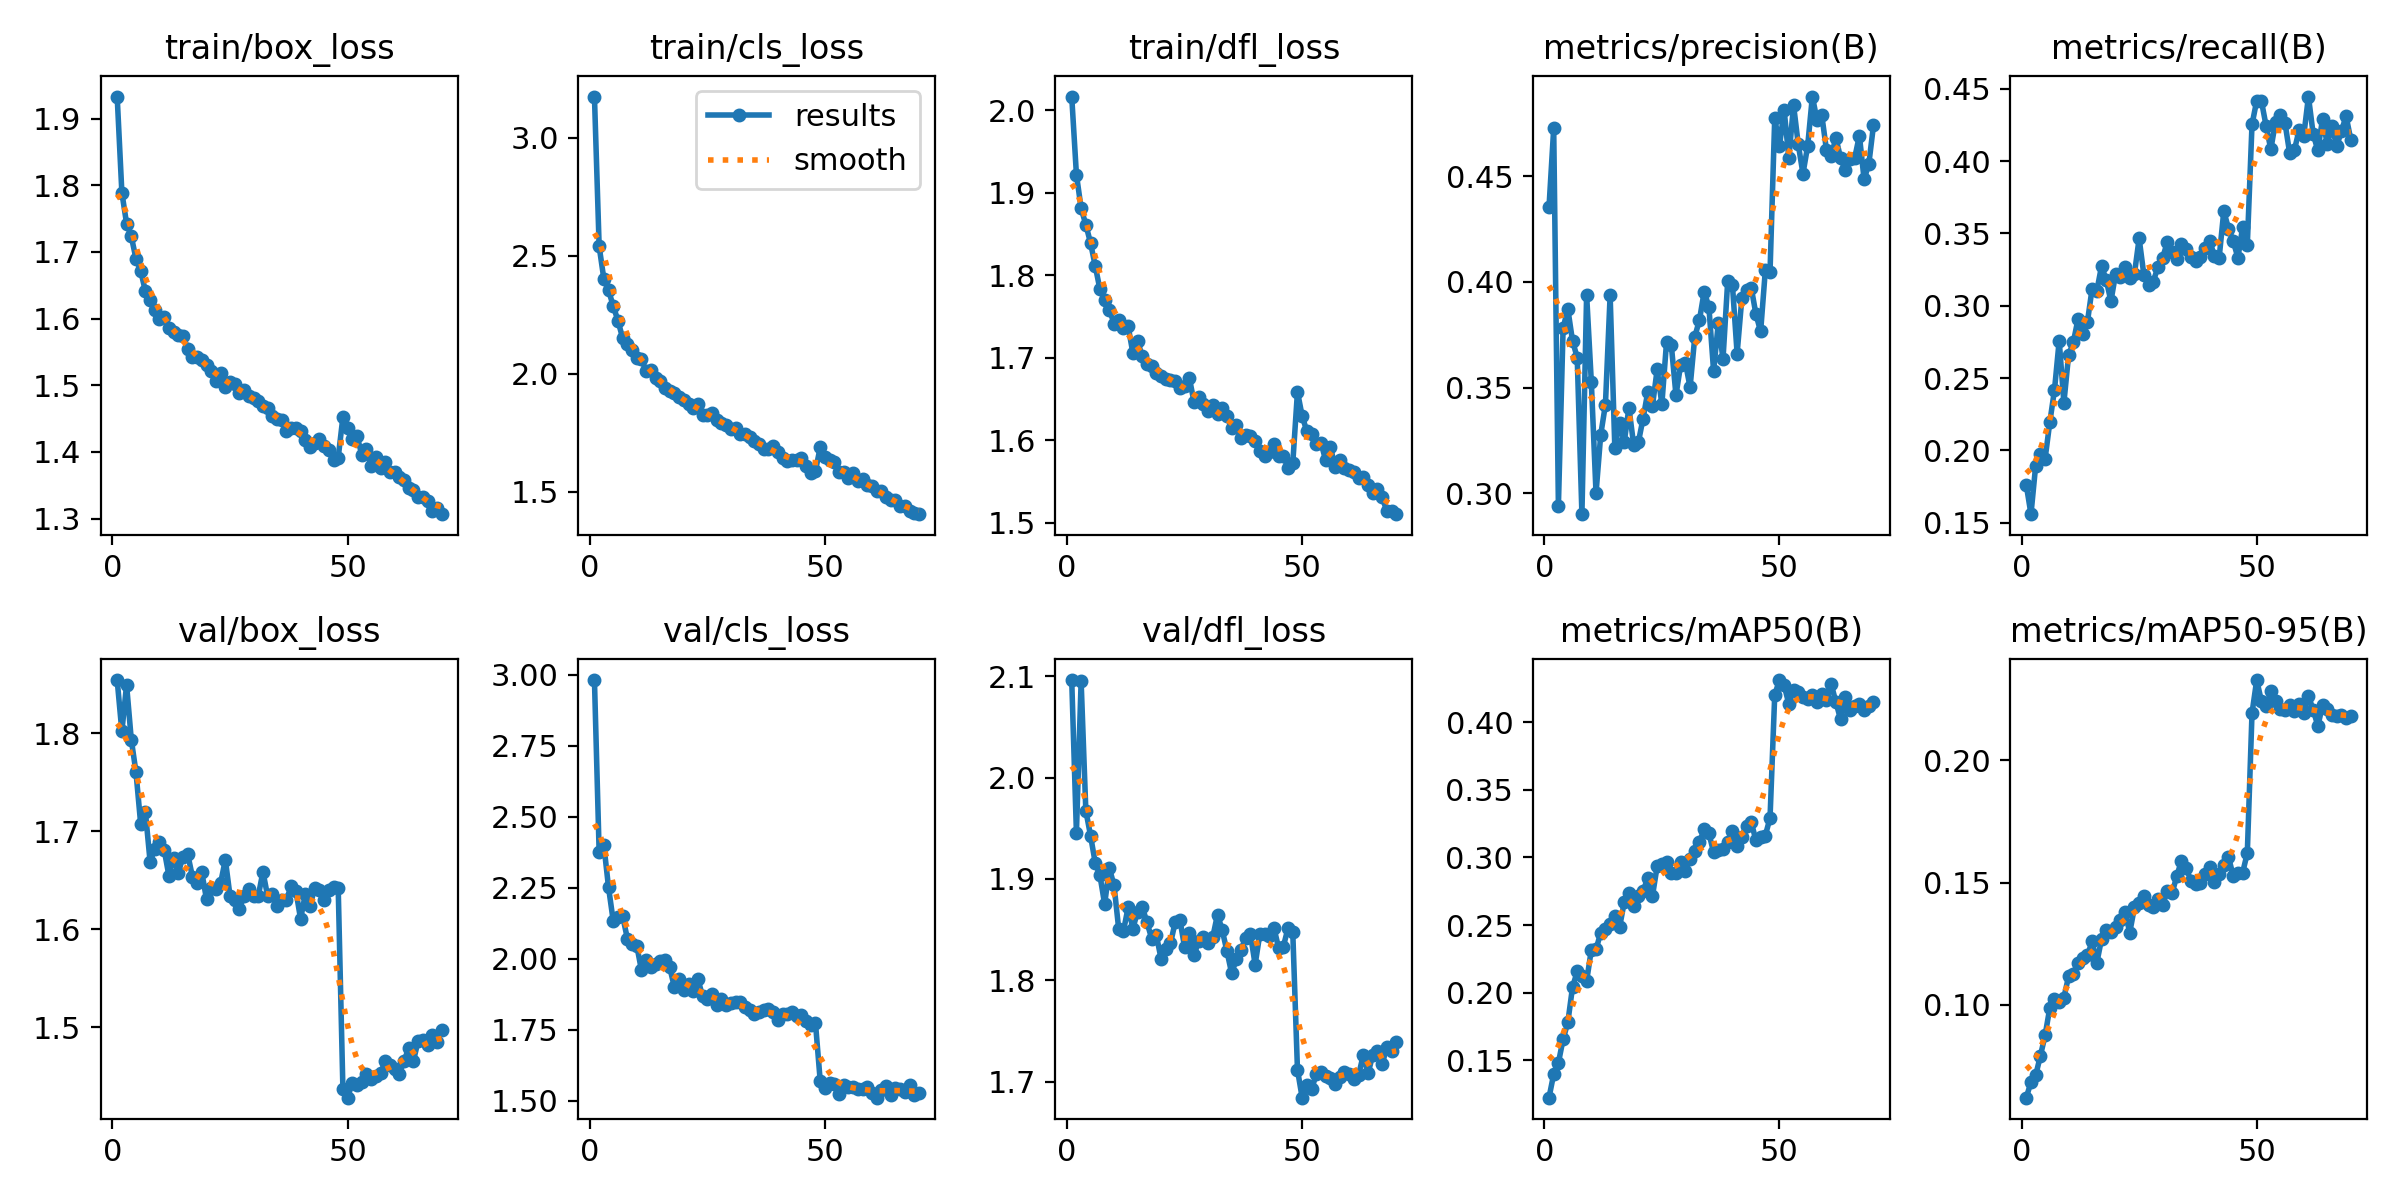

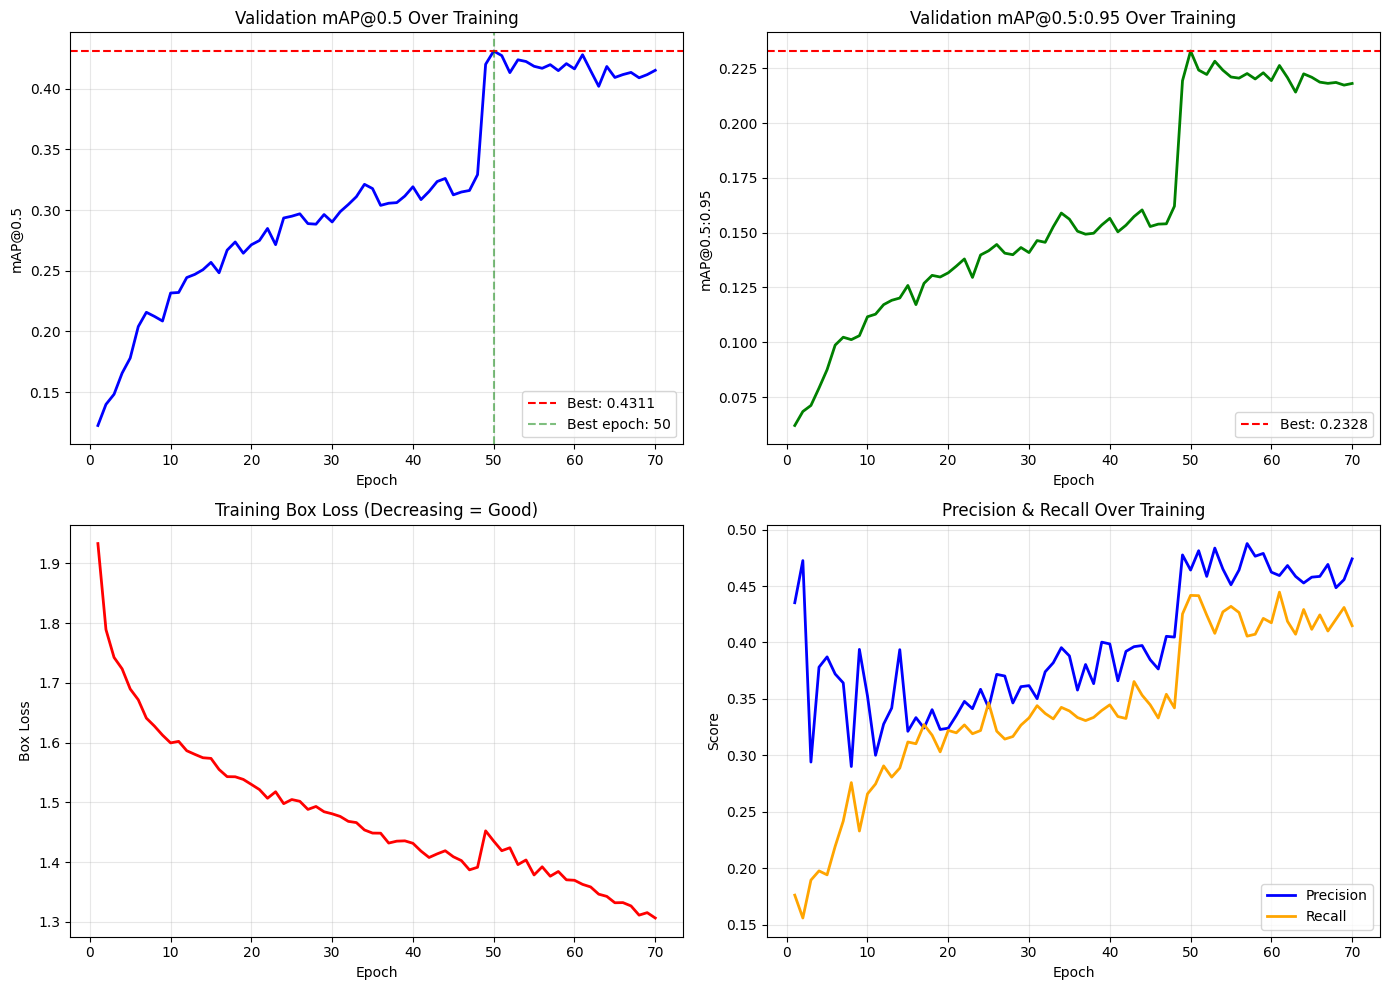


✅ Training analysis plot saved to /content/training_analysis.png


In [16]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import pandas as pd
import os

# Correct paths for your run!
results_csv = "/content/drive/MyDrive/CliniScan_Training/yolov8m_vinbig_1024/results.csv"
results_img = "/content/drive/MyDrive/CliniScan_Training/yolov8m_vinbig_1024/results.png"

# Load CSV
if os.path.exists(results_csv):
    df = pd.read_csv(results_csv)
else:
    print("❌ Results CSV not found at", results_csv)

# Display the comprehensive results plot
if os.path.exists(results_img):
    print("📊 Complete Training Curves:")
    display(Image(filename=results_img, width=1000))
else:
    print("❌ Results image not found at", results_img)

# Custom plot showing the peak
if 'df' in locals():
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Plot 1: mAP50
    axes[0, 0].plot(df['epoch'], df['metrics/mAP50(B)'], 'b-', linewidth=2)
    axes[0, 0].axhline(y=df['metrics/mAP50(B)'].max(), color='r', linestyle='--', label=f'Best: {df["metrics/mAP50(B)"].max():.4f}')
    best_epoch = df['metrics/mAP50(B)'].idxmax()
    axes[0, 0].axvline(x=df['epoch'][best_epoch], color='g', linestyle='--', alpha=0.5, label=f'Best epoch: {df["epoch"][best_epoch]}')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('mAP@0.5')
    axes[0, 0].set_title('Validation mAP@0.5 Over Training')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Plot 2: mAP50-95
    axes[0, 1].plot(df['epoch'], df['metrics/mAP50-95(B)'], 'g-', linewidth=2)
    axes[0, 1].axhline(y=df['metrics/mAP50-95(B)'].max(), color='r', linestyle='--', label=f'Best: {df["metrics/mAP50-95(B)"].max():.4f}')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('mAP@0.5:0.95')
    axes[0, 1].set_title('Validation mAP@0.5:0.95 Over Training')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Plot 3: Training Loss
    axes[1, 0].plot(df['epoch'], df['train/box_loss'], 'r-', linewidth=2)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Box Loss')
    axes[1, 0].set_title('Training Box Loss (Decreasing = Good)')
    axes[1, 0].grid(True, alpha=0.3)

    # Plot 4: Precision & Recall
    axes[1, 1].plot(df['epoch'], df['metrics/precision(B)'], 'b-', linewidth=2, label='Precision')
    axes[1, 1].plot(df['epoch'], df['metrics/recall(B)'], 'orange', linewidth=2, label='Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].set_title('Precision & Recall Over Training')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('/content/training_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\n✅ Training analysis plot saved to /content/training_analysis.png")

In [17]:
import os

# Quick check
print("📋 Final Verification:")
print(f"  ✅ Train images: {len(os.listdir('/content/yolo_dataset/images/train'))}")
print(f"  ✅ Val images: {len(os.listdir('/content/yolo_dataset/images/val'))}")
print(f"  ✅ YAML config: {os.path.exists('/content/data_vinbig.yaml')}")
print(f"  ✅ Model in Drive: {os.path.exists('/content/drive/MyDrive/CliniScan_Training/yolov8m_vinbig_1024/weights/best.pt')}")
print("\n🚀 Everything ready for predictions!")

📋 Final Verification:
  ✅ Train images: 12000
  ✅ Val images: 3000
  ✅ YAML config: True
  ✅ Model in Drive: True

🚀 Everything ready for predictions!


In [18]:
from ultralytics import YOLO

# Load your trained model
print("📥 Loading best model...")
model = YOLO("/content/drive/MyDrive/CliniScan_Training/yolov8m_vinbig_1024/weights/best.pt")
print("✅ Model loaded!")

# Run predictions
print("\n🔍 Running predictions on validation set...")
print("⏱  This will take ~5-10 minutes for ~897 images...")

results = model.predict(
    source="/content/yolo_dataset/images/val",
    save=True,              # Save images with bounding boxes
    conf=0.25,              # Confidence threshold
    save_txt=True,          # Save detection coordinates
    save_conf=True,         # Save confidence scores in txt
    line_width=2,           # Bounding box line width
    project="/content/predictions",
    name="cliniscan_val_results"
)

print(f"\n✅ Predictions complete!")
print(f"📊 Processed {len(results)} validation images")
print(f"📁 Results saved to: /content/predictions/cliniscan_val_results/")

📥 Loading best model...
✅ Model loaded!

🔍 Running predictions on validation set...
⏱  This will take ~5-10 minutes for ~897 images...

WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/3000 /content/yolo_dataset/images/val/000434271f63a053c4128a0ba6352c7f.jpg: 1024x1024 2 Aortic_enlargements, 2 Cardiomegalys, 76.3ms
image 2/3000 /content/yolo_dataset/images/val/00291f7aff0123ea76a59998effef229.jpg: 1024x1024 (no detections), 76.4ms
image 3/3000 /content/yolo_dataset/images/val/003cfe5ce5c0ec51

In [19]:
import os
import matplotlib.pyplot as plt
from collections import Counter

pred_dir = "/content/predictions/cliniscan_val_results/labels"

# Count detections per image
detection_counts = []
class_detections = Counter()

for label_file in os.listdir(pred_dir):
    with open(os.path.join(pred_dir, label_file), 'r') as f:
        lines = f.readlines()
        detection_counts.append(len(lines))
        # Count each class
        for line in lines:
            class_id = int(line.split()[0])
            class_detections[class_id] += 1

# Dynamically count validation images
val_img_count = len(detection_counts)
total_detections = sum(detection_counts)
images_with_detections = len([x for x in detection_counts if x > 0])
images_without_detections = val_img_count - images_with_detections

print("📊 Detection Statistics:")
print(f"   Total detections across all images: {total_detections}")
print(f"   Images with detections: {images_with_detections} ({100*images_with_detections/val_img_count:.1f}%)")
print(f"   Images with no detections: {images_without_detections} ({100*images_without_detections/val_img_count:.1f}%)")
print(f"   Average detections per image: {total_detections/val_img_count:.2f}")
print(f"   Max detections in single image: {max(detection_counts)}")

📊 Detection Statistics:
   Total detections across all images: 5545
   Images with detections: 2048 (100.0%)
   Images with no detections: 0 (0.0%)
   Average detections per image: 2.71
   Max detections in single image: 26


🖼  Sample Predictions with Detections:

Sample 1:


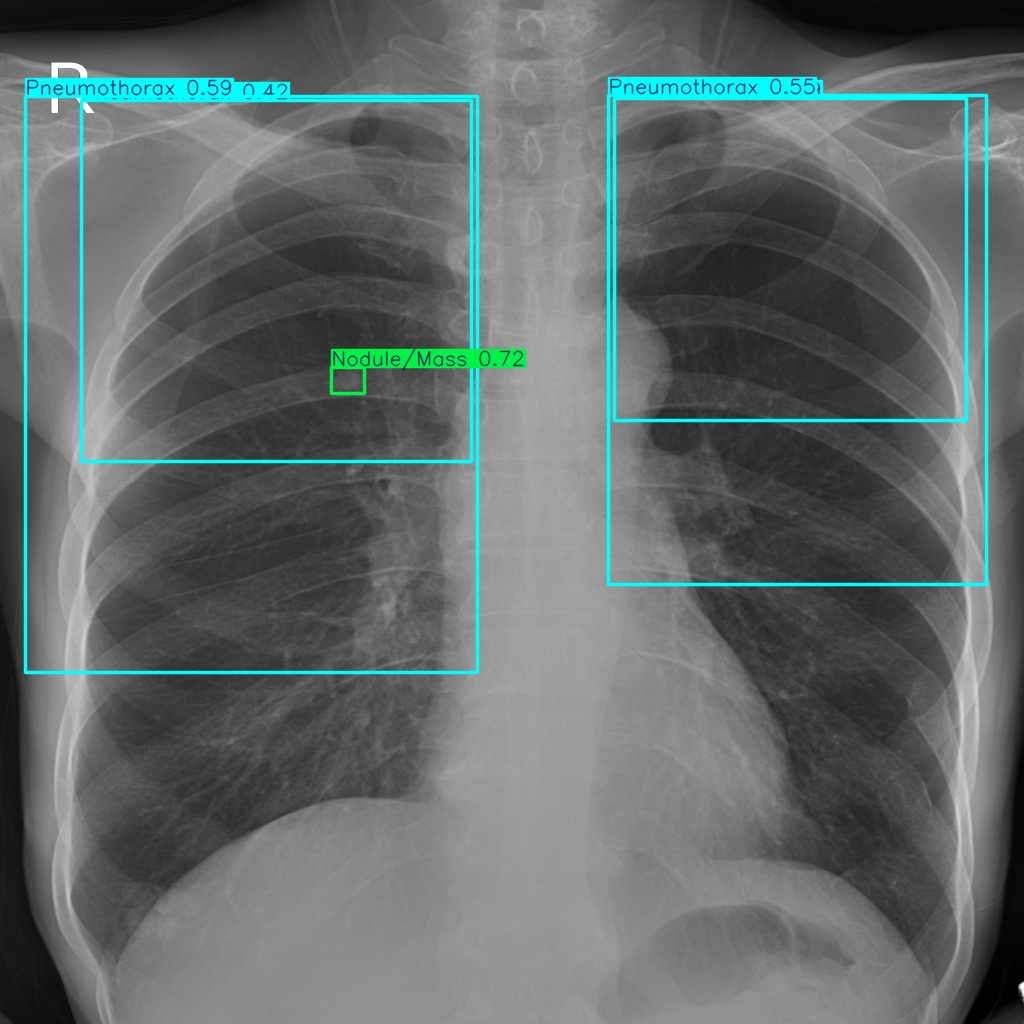



Sample 2:


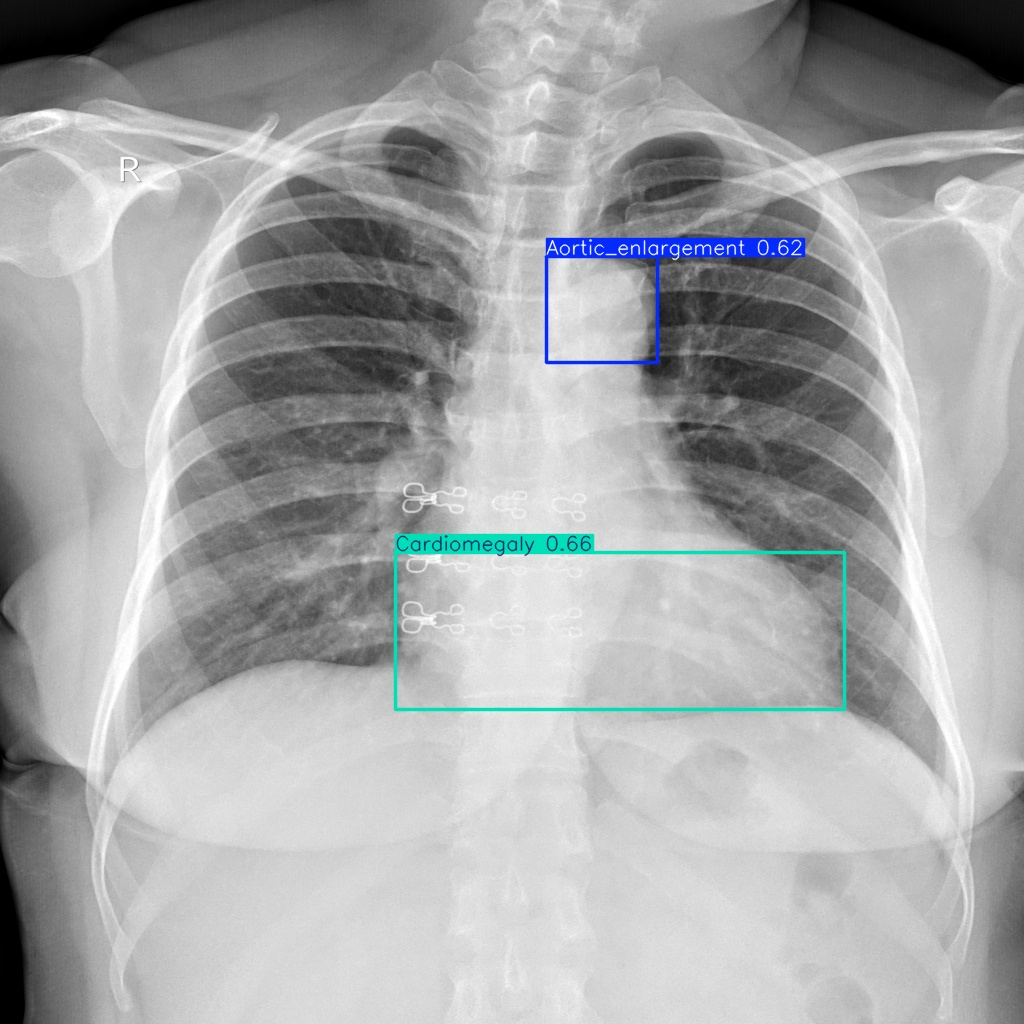



Sample 3:


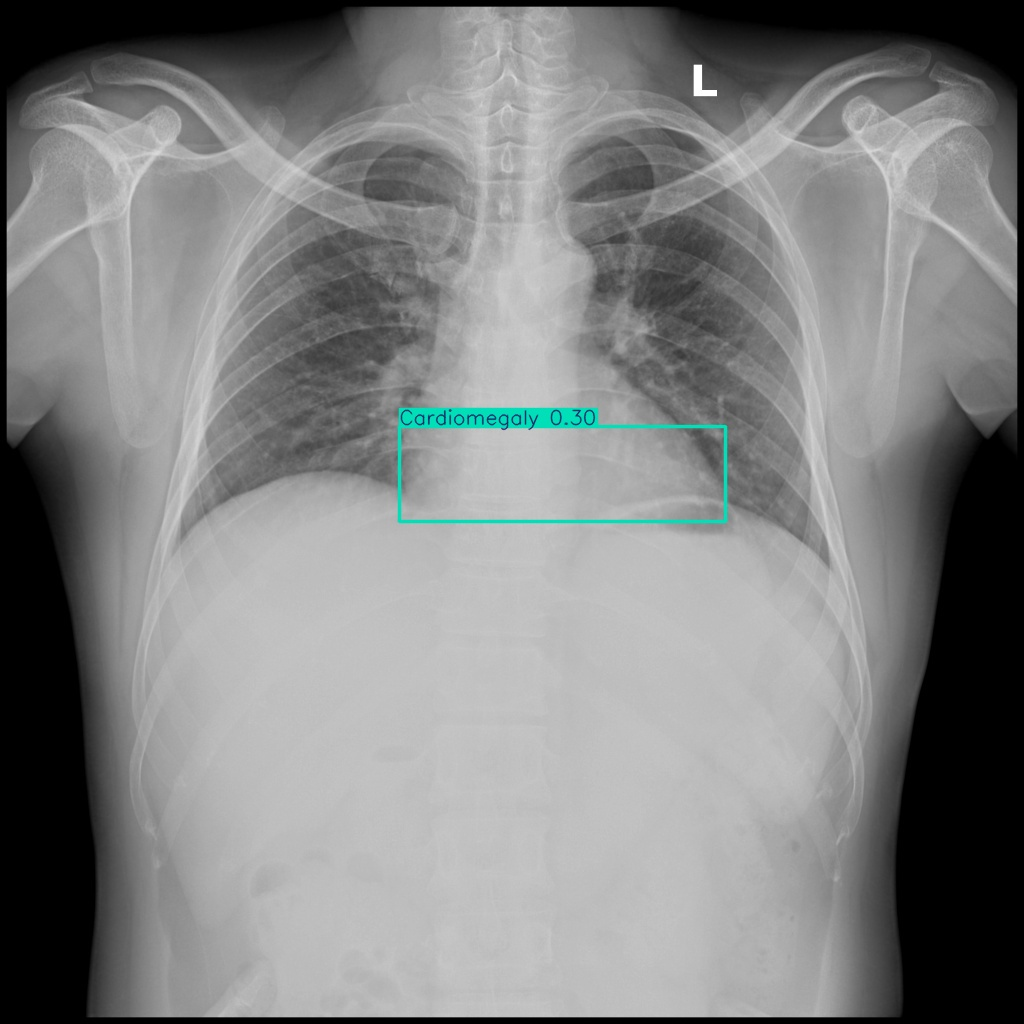



Sample 4:


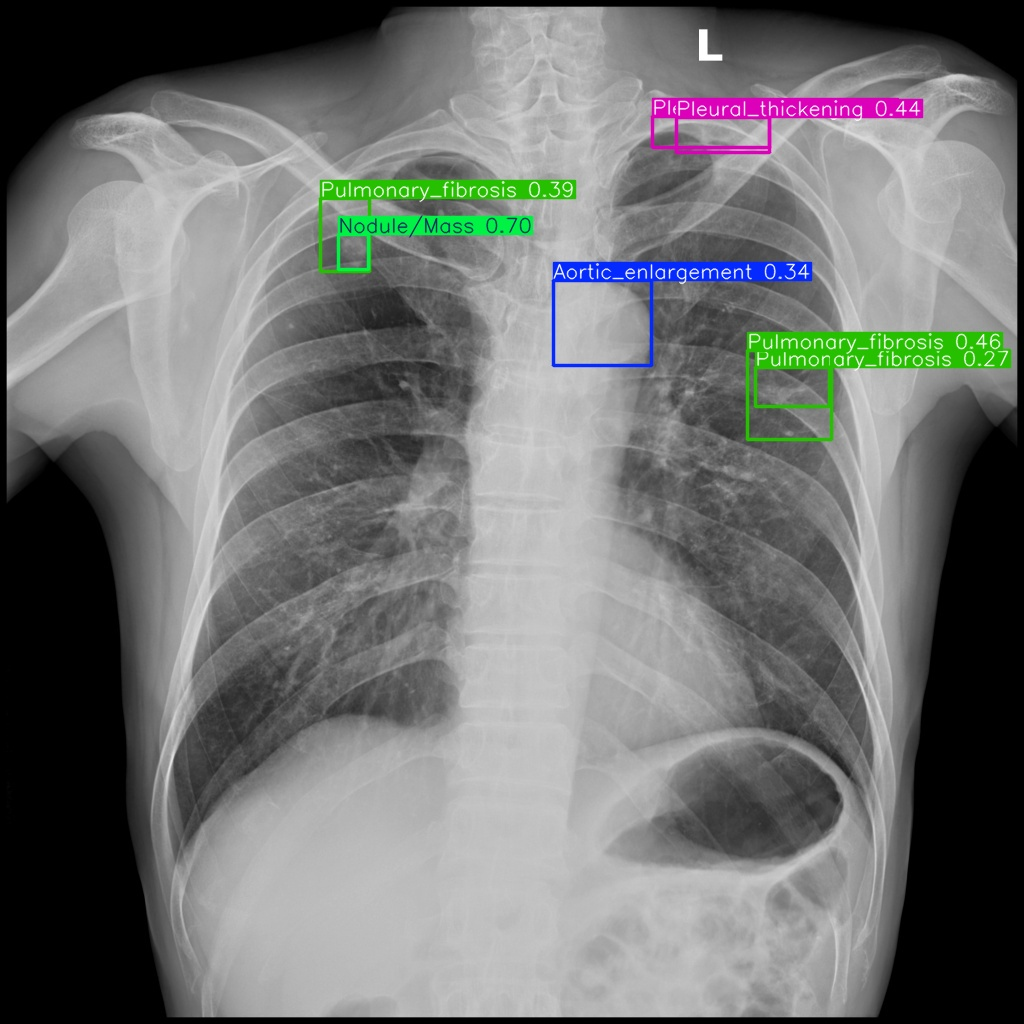



Sample 5:


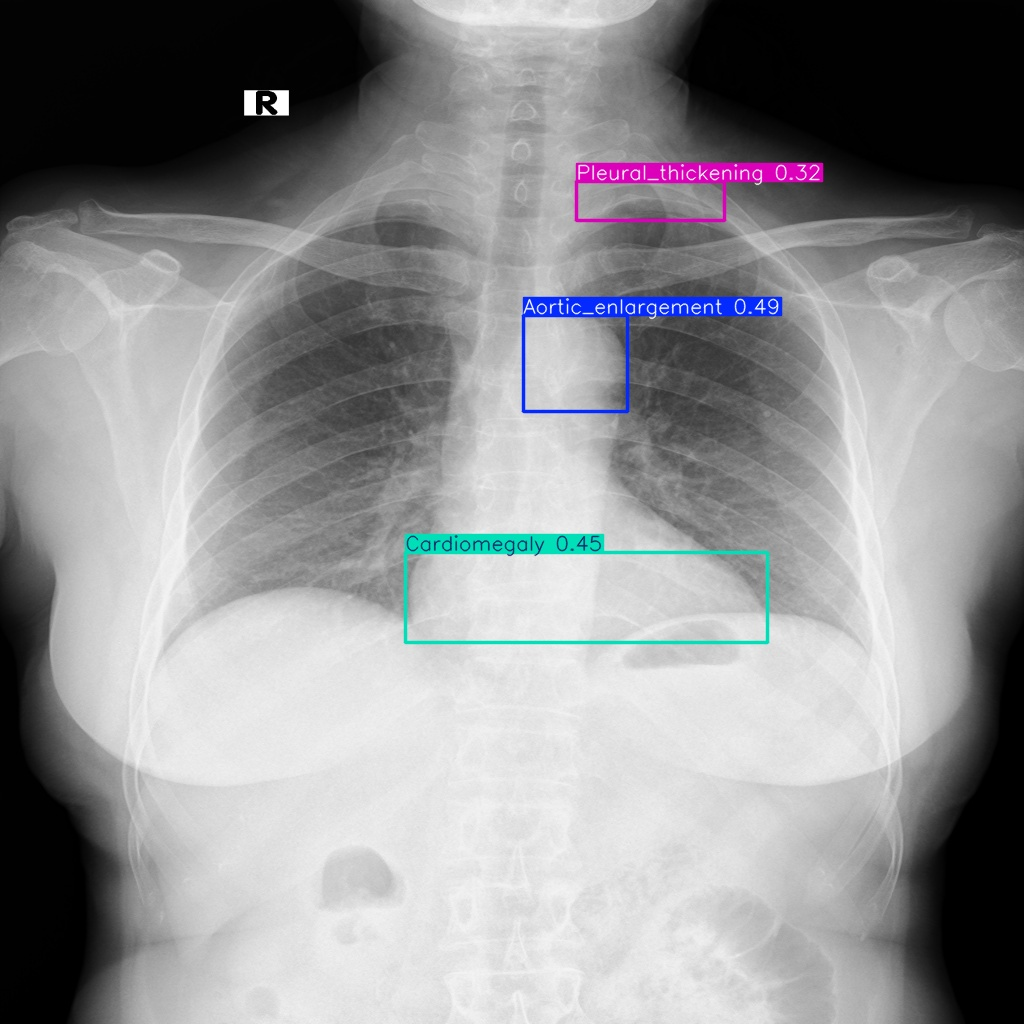

In [20]:
from IPython.display import Image, display
import glob
import random

# Get prediction images
pred_images = glob.glob("/content/predictions/cliniscan_val_results/*.jpg")

# Show 5 random predictions
print("🖼  Sample Predictions with Detections:\n")
random.shuffle(pred_images)

for i, img_path in enumerate(pred_images[:5], 1):
    print(f"Sample {i}:")
    display(Image(filename=img_path, width=700))
    print("\n" + "="*80 + "\n")

In [21]:
import shutil
import os

source = "/content/predictions/cliniscan_val_results"
destination = "/content/drive/MyDrive/CliniScan_Predictions"

print("💾 Backing up predictions to Google Drive...")
shutil.copytree(source, destination, dirs_exist_ok=True)
print("✅ Predictions saved to Drive!")
print(f"📁 Location: {destination}")

# Count only annotated images
image_count = len([f for f in os.listdir(destination) if f.endswith('.jpg')])
print(f"   - {image_count} annotated images")
print(f"   - Detection coordinates in labels/ folder")

💾 Backing up predictions to Google Drive...
✅ Predictions saved to Drive!
📁 Location: /content/drive/MyDrive/CliniScan_Predictions
   - 3000 annotated images
   - Detection coordinates in labels/ folder


In [24]:
import shutil
import os

# Define paths for weights, predictions, and analysis files
weights_src = "/content/drive/MyDrive/CliniScan_Training/yolov8m_vinbig_1024/weights"
weights_dst = "/content/drive/MyDrive/CliniScan_Project/weights"

pred_src = "/content/predictions/cliniscan_val_results"
pred_dst = "/content/drive/MyDrive/CliniScan_Project/predictions/cliniscan_val_results"

yaml_src = "/content/data_vinbig.yaml"
yaml_dst = "/content/drive/MyDrive/CliniScan_Project/data_vinbig.yaml"

csv_src = "/content/drive/MyDrive/CliniScan_Training/yolov8m_vinbig_1024/results.csv"
csv_dst = "/content/drive/MyDrive/CliniScan_Project/results.csv"

plot_src = "/content/prediction_analysis.png"
plot_dst = "/content/drive/MyDrive/CliniScan_Project/prediction_analysis.png"

# Copy weights (with checkpoints)
shutil.copytree(weights_src, weights_dst, dirs_exist_ok=True)

# Copy predictions (annotated images and labels)
shutil.copytree(pred_src, pred_dst, dirs_exist_ok=True)

# Copy YAML configuration, CSV summary, and analysis plot
shutil.copy2(yaml_src, yaml_dst)
shutil.copy2(csv_src, csv_dst)
shutil.copy2(plot_src, plot_dst)

print("✅ All key assets backed up to Google Drive (CliniScan_Project folder).")
print("Contents:")
print(f" - Weights: {weights_dst} [{len(os.listdir(weights_dst))} files]")
print(f" - Predictions: {pred_dst} [{len(os.listdir(pred_dst))} images]")
print(f" - Labels: {os.path.join(pred_dst,'labels')} [{len(os.listdir(os.path.join(pred_dst,'labels')))} label files]")
print(f" - YAML config: {yaml_dst}")
print(f" - Training CSV: {csv_dst}")
print(f" - Analysis plot: {plot_dst}")

FileNotFoundError: [Errno 2] No such file or directory: '/content/prediction_analysis.png'